<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [9]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
#from plotly.offline import iplot

In [2]:
# Cargar datos
path = "reviews_vidjew_es (1).csv"
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
#se realiza revision - balanceo de datos
data.review_body.value_counts(normalize = True)

Calidad precio buena                                                                                                                                                                                                                                                                                                                           0.002
Buenos materiales y muy buena calidad de sonido a un muy buen precio. Las almohadillas son bastante grandes y al cabo de unas horas usándolos no molestan nada. Vienen con un regulador de sonido y puedes silenciar el micrófono diréctamente en el cable. El micrófono se abate para que no esté molestando si no se usa. Recomiendo 100%    0.001
Se ha puesto negra literalmente a los 3 días y destiñe la piel en verde. Pésima calidad.                                                                                                                                                                                                                                      

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d]+", " ", texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())


###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [15]:
ks = []
k_inertias = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)

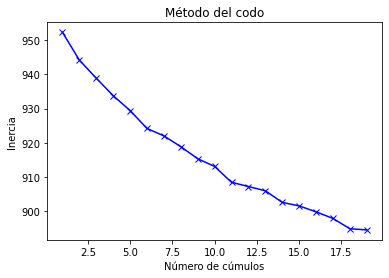

In [16]:
# list(zip(ks,k_inertias))

plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');


In [17]:
k = 30
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
data['cluster'] = model.labels_
data

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,3
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,28
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,28
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,29
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,4
...,...,...,...,...,...,...,...,...,...
995,es_0427672,product_es_0899883,reviewer_es_0474735,2,En la foto parece que la cadena sea más gruesa...,Cadena muy fina,es,jewelry,1
996,es_0059540,product_es_0702564,reviewer_es_0754753,3,"Bien por su precio, la cadena demasiado fina.",E,es,jewelry,29
997,es_0303349,product_es_0678671,reviewer_es_0172313,5,Muy bien!! Ahora tengo organizados los pendien...,Bonito,es,jewelry,4
998,es_0659961,product_es_0294943,reviewer_es_0554554,4,"Las tapas para los joystics no están nada mal,...",No está mal pero sólo he probado las fundas.,es,video_games,23


`[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [19]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_



###  `[15 pts]` Punto 4: Interpretación de los clusters

In [23]:
terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 16 registros (1.60% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
bonita muy es pero queda la se mojes no con acabado puesta chillon pone regalo elegante oxida fina magnífico rosa 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** Es fina pero muy bonita y elegante

 *** Muy bonita y de buena calidad. Tiene el peso justo y el tamaño perfecto. No se hace pesada en la mano y queda muy bonita puesta.

 *** Es muy bonita, pero no la mojes porque se oxida.


********************************************

Cluster # 1
Tiene 58 registros (5.80% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
que no se el puede es pedir precio más por tiene mucho pero lo la un fina en muy poco 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** No es muy fina, pero por el precio que tiene poco más se puede pedir.

 *** Un ratón que por el precio no se le puede pedir más

 *** Está bien es como esperaba, por el precio que tiene no se puede pedir más tardó en llegar, pero llegó en perfectas condiciones.


***********************

In [ ]:
clusters = {0: 'Buen material y acabado',
            1: 'Inconformidad con llegada',
            2: 'Buena relación calidad-precio',
            3: 'StopWord (no lo pude remover)',
            4: 'Bonito con observaciones',
            5: 'StopWord (no lo pude remover)',
            6: 'Conforme con la logística',
            7: 'Conforme con la forma en que le quedan',
            8: 'Compró para regalar',
            9: 'Bonitos pero pequeños'}

data['nombres_clusters'] = data['cluster'].apply(lambda val: clusters[val])
data.sample(17)

###  `[BONUS: 3 pts]` Visualización usando PCA

# Comparación

### `[BONUS 20 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [ ]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?

# agrupa objetos en k grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o cluster.

#k-means se puede determinar como un modelo mas avanzado y con mayor precision 

